In [3]:
from langgraph.graph import StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

import operator

from pydantic import BaseModel, Field

In [48]:
from typing import Annotated, Optional, Sequence, List, Literal, TypedDict

In [5]:
from prompts import transform_messages_into_research_topic_prompt, clarify_with_user_instructions

## Define States

In [6]:
class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from the user input"""
    pass

In [7]:
class AgentState(MessagesState):
    """Main state for the full agent research system
    
    We have additional fields for research coordination"""

    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str


In [49]:
class ResearcherState(TypedDict):
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iteration: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    compressed_research:str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]



## Structured Output Schemas

In [8]:
class ClarifyWithUser(BaseModel):
    """Schema for clarification decision and question"""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying questions")
    
    question: str = Field(
        description="A question to ask the user to clarify the report scope")
     
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )
    


In [9]:
class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation"""
    research_brief: str = Field(
        description="A research question that would be used to guide the research"
    )

In [50]:
class Summary(BaseModel):
    "Schema for webpage content summarization"
    summary: str = Field(description="Consize summary of the webpage content")
    key_excerpts:str = Field(description="Important quotes and excerpts from the content")

In [11]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

# from langchain_openai import ChatOpenAI
# openai_model = ChatOpenAI(model= 'gpt-4o', temperature=0.0)

from langchain_groq import ChatGroq

model = ChatGroq(model='llama-3.3-70b-versatile', 
                 api_key=os.environ.get("GROQ_API_KEY"),
                 temperature=0.0)

In [52]:
summarization_model = ChatGroq(model='groq/compound', 
                 api_key=os.environ.get("GROQ_API_KEY"),
                 temperature=0.0)

## Start working on clarification node and reseach brief

In [12]:
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string

from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, Interrupt

input - > check clarifying question -yes.  -> ask question
                                    - no   -> generate brief

In [13]:
from datetime import datetime

In [14]:
def get_today_str()->str:
    return datetime.now().strftime("%a %b %-d, %Y")

In [15]:
def clarify_with_user(state: AgentInputState) ->Command[Literal["write_research_brief","__end__"]]:
    

    structured_llm = model.with_structured_output(ClarifyWithUser)

    prompt_ = clarify_with_user_instructions.format(messages=get_buffer_string(state['messages']), date=get_today_str())
    response = structured_llm.invoke([HumanMessage(content=prompt_)])

    if response.need_clarification:
        return Command(goto=END,
                       update={"messages":[AIMessage(content=response.question)]})
    
    else:
        return Command(
            goto="write_research_brief",
            update={"messages":[AIMessage(content=response.verification)]}
        )


    

In [16]:
def write_research_brief(state:AgentState):
    """
    Transform the conversation history into a comprehensive research brief"""

    structured_output_model = model.with_structured_output(ResearchQuestion)

    _prompt = transform_messages_into_research_topic_prompt.format(messages = get_buffer_string(state.get("messages",[])),
                                                                                              date=get_today_str()
                                                                )
    response = structured_output_model.invoke([HumanMessage(content=_prompt)])

    return {
        "research_brief":response.research_brief,
        "supervisor_messages":[HumanMessage(content=f"{response.research_brief}.")]
    }

## Graph Construction

In [17]:
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)

deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

scope_research = deep_researcher_builder.compile()

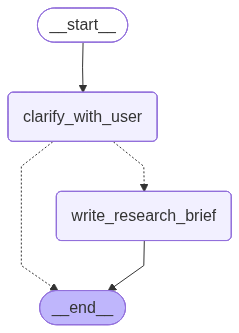

In [18]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [19]:
# Run the workflow
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I have sufficient information to proceed. I understand that you want to research the best coffee shops in San   │
│ Francisco. I will now begin the research process to provide you with the desired information.                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [20]:
print(result['research_brief'])

As I want to research the best coffee shops in San Francisco, I would like to investigate key attributes such as coffee quality, atmosphere, and customer service, considering all price ranges unless cost constraints are specified, and prioritizing official reviews from sources like Yelp and Google, while also considering social media and blogs for a comprehensive view, without assuming any specific preferences for factors like location, menu offerings, or amenities, and focusing on the city of San Francisco as the primary geographical scope.


## Define Agent States

## WorkFlow

call llm -> should continnue -> tool node.  -> back to call llm.  -> compress - > generate output

In [30]:
prompt_researcher = """
You are helpful assistant tasked with doing the research on the following topic

<topic>
{research_brief}
</topic>

Research notes uptil now
<notes>
{notes}
</notes>

Today's date is {date}

You can use search tools at your disposle. When you are done with searche and research kindly acknowledge

<Guidelines>
1. Start with broader searches and then narrow down your search
2. As and when you need more information use search tool to get it
3. Do not look for perfection. If you have good enough material you can conclude your research.
</Guidelines>
"""

In [ ]:
summarize_webpage_prompt="""
You are tasked with summarizing the raw content of the webpage retrieved from a web search.
Your goal is to preserve most important information from the webpage.

Here is the raw content of the webpage:
<webpage_content>
{webpage_content}
</webpage_content>

Please follow these guidelines while creating your summary:

1. Identify and preserve the main topic or purpose of the webpage.
2. Retain key facts, statistics, and data points that are central to the content's message.
3. Keep important quotes from credible sources or experts.
4. Maintain the chronological order of events if the content is time-sensitive or historical.
5. Preserve any lists or step-by-step instructions if present.
6. Include relevant dates, names, and locations that are crucial to understanding the content.
7. Summarize lengthy explanations while keeping the core message intact.

When handling different types of content:

- For news articles: Focus on the who, what, when, where, why, and how.
- For scientific content: Preserve methodology, results, and conclusions.
- For opinion pieces: Maintain the main arguments and supporting points.
- For product pages: Keep key features, specifications, and unique selling points.

Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is already concise.

Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage.

Today's date is {date}.
"""

In [45]:
from tavily import TavilyClient
tavily_client = TavilyClient()

In [ ]:
def tavily_search_multiple(
        search_queries: List[str],
        max_results: int = 3,
        topic: Literal["general", "news", "finance"] = "general",
        include_raw_content: bool = True,
) -> List[dict]:
    """
    Performs search using tavily API for multple queries"""

    search_docs = []

    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            topic=topic,
            include_raw_content=include_raw_content
        )
        search_docs.append(result)

    return search_docs

In [ ]:
def summarize_webpage_content(webpage_content:str) -> str:
    """Summarize webpage content using the summarization model.
    
    Args:
        webpage_content: Raw webpage content to be summarized
    Returns:
        formatted summary with key excerpts
    """

    try:
        structured_model = summarization_model.with_structured_output(Summary)

        _prompt = summarize_webpage_prompt.format(webpage_content=webpage_content, date=get_today_str())

        summary = structured_model.invoke(
            [HumanMessage(content=_prompt)]
            )
        
        formatted_summary =(
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary
    
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content


In [ ]:
def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results


In [ ]:
def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    
    return summarized_results

In [ ]:
def format_search_output(summarized_results:dict) ->str:
    """Format Search results into well-strucuted string output
    
    Args:
        summarized_results: Dictionary of processed search results
    Returns:
        Formatted string of search results with clear source seperation
    """

    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMRY: \n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    return formatted_output

In [60]:
from langchain_core.tools import tool, InjectedToolArg

@tool(parse_docstring=True)
def tavily_search(
    query:str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general") ->str:

    """Fetch results from Tavily search API with content summarization.
    
    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', finance)

    Returns:
        Formatted string of search results with summaries
    """
    
    search_results = tavily_search_multiple(
        [query],
        max_results=max_results,
        topic =topic,
        include_raw_content=True
    )
    unique_results = deduplicate_search_results(search_results)

    summarized_results = process_search_results(unique_results)

    return format_search_output(summarized_results)


    

In [61]:
@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"


In [ ]:
tools = [tavily_search, think_tool]
tools_by_name = {tool.name:tool for tool in tools}

model_with_tools = model.bind_tools(tools)

In [ ]:
def llm_call(state: ResearcherState):

    _prompt = prompt_researcher.format(research_brief = state['research_brief'], date = get_today_str(),notes = state['notes'])

    response = model_with_tools.invoke([HumanMessage(content=_prompt)])

    return {'messages':response}

In [38]:
llm_call(result)

{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qa4azjsvs', 'function': {'arguments': '{"query":"best coffee shops in San Francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 491, 'total_tokens': 509, 'completion_time': 0.042795845, 'prompt_time': 0.040819964, 'queue_time': 0.524278595, 'total_time': 0.083615809}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--545256bc-5649-4bde-bf40-73dcf629dcc0-0', tool_calls=[{'name': 'search', 'args': {'query': 'best coffee shops in San Francisco'}, 'id': 'qa4azjsvs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 491, 'output_tokens': 18, 'total_tokens': 509})}

In [ ]:
def tool_node(state:AgentState):

    last_message = state['messages'][-1]

    tool - > run thsi tool

    return {
        "messages":response
    }

In [ ]:
def should_continue(state:AgentState):

    #check last message if its is tool call

    last_message = state['messages'][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    else:
        return "compress_research"

In [36]:
result['messages'][-1]

AIMessage(content='I have sufficient information to proceed. I understand that you want to research the best coffee shops in San Francisco. I will now begin the research process to provide you with the desired information.', additional_kwargs={}, response_metadata={}, id='4d817856-b21e-4269-9dc2-8a6d1715a150')